## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_02.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

Sprawdzone modele to:
1. Model bazowy - **Regresja liniowa**
2. Model docelowy - **Las losowy**

W procesie trenowania modelu używana jest metoda **walidacji krzyżowej**.

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

In [2]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [3]:
import pandas as pd
from src.transformations.target import convert_price_to_number
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = convert_price_to_number(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=1,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

X = listings
y = target
cv = KFold(n_splits=5, shuffle=True, random_state=13)

#### Model bazowy - regresja liniowa

In [4]:
from sklearn.linear_model import LinearRegression

pipe_linear = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_linear.fit(X, y)

print(f"Mean CV linear MAE: {mae.mean():.2f} ± {mae.std():.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    1166 non-null   object 
 1   room_type                        1166 non-null   object 
 2   accommodates                     1166 non-null   int64  
 3   bathrooms                        1165 non-null   float64
 4   bedrooms                         1157 non-null   float64
 5   beds                             1095 non-null   float64
 6   host_response_time               1025 non-null   object 
 7   host_response_rate               1025 non-null   float64
 8   host_acceptance_rate             1093 non-null   float64
 9   host_is_superhost                1104 non-null   Int64  
 10  host_identity_verified           1166 non-null   Int64  
 11  review_scores_rating             980 non-null    float64
 12  number_of_reviews   

#### Model docelowy - random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

pipe_random_forest = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_jobs=-1)),
    ]
)

cv_scores = cross_val_score(pipe_random_forest, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_random_forest.fit(X, y)

print(f"Mean CV random forest MAE: {mae.mean():.2f} ± {mae.std():.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    1166 non-null   object 
 1   room_type                        1166 non-null   object 
 2   accommodates                     1166 non-null   int64  
 3   bathrooms                        1165 non-null   float64
 4   bedrooms                         1157 non-null   float64
 5   beds                             1095 non-null   float64
 6   host_response_time               1025 non-null   object 
 7   host_response_rate               1025 non-null   float64
 8   host_acceptance_rate             1093 non-null   float64
 9   host_is_superhost                1104 non-null   Int64  
 10  host_identity_verified           1166 non-null   Int64  
 11  review_scores_rating             980 non-null    float64
 12  number_of_reviews   

In [6]:
from sklearn.model_selection import GridSearchCV

# 1. Definiujemy param_grid
# Używamy nazw kroków z Twojego Pipeline: "regressor"
param_grid = {
    "regressor__n_estimators": [50, 100, 150],
    "regressor__max_depth": [10, 12, 15, 17],
    "regressor__min_samples_split": [5, 10, 20],
    "regressor__min_samples_leaf": [4, 6, 8]
}

# 2. Inicjalizujemy GridSearchCV
# Przekazujemy Twój pipeline oraz param_grid
grid_search = GridSearchCV(
    estimator=pipe_random_forest,
    param_grid=param_grid,
    cv=5,  # liczba podziałów w walidacji krzyżowej
    scoring="neg_mean_absolute_error",
    n_jobs=-1,  # wykorzystaj wszystkie rdzenie
    verbose=2,
    refit=True  # automatycznie wytrenuje najlepszy model na całym zbiorze X, y
)

# 3. Uruchamiamy przeszukiwanie
# To zastępuje ręczne wywoływanie cross_val_score i fit
grid_search.fit(X, y)

# 4. Wyświetlamy wyniki
best_mae = -grid_search.best_score_
print(f"Najlepsze średnie MAE z CV: {best_mae:.2f}")
print(f"Najlepsze parametry: {grid_search.best_params_}")

# Teraz 'grid_search' działa jak Twój wytrenowany model z najlepszymi parametrami
# Możesz od razu robić predykcje:
# predictions = grid_search.predict(X_new)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    1166 non-null   object 
 1   room_type                        1166 non-null   object 
 2   accommodates                     1166 non-null   int64  
 3   bathrooms                        1165 non-null   float64
 4   bedrooms                         1159 non-null   float64
 5   beds                             1096 non-null   float64
 6   host_response_time               1040 non-null   object 
 7   host_response_rate               1040 non-null   float64
 8   host_acceptance_rate             1100 non-null   float64
 9   host_is_superhost                1115 non-null   Int64  
 10  host_identity_verified           1166 non-null   Int64  
 11  review_scores_ratin

/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/par

[CV] END regressor__max_depth=10, regressor__min_samples_leaf=8, regressor__min_samples_split=10, regressor__n_estimators=150; total time=   4.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=8, regressor__min_samples_split=10, regressor__n_estimators=150; total time=   4.2s


/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/sus/IUM/IUM/.venv/lib/python3.14/site-packages/sklearn/utils/par

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    292 non-null    object 
 1   room_type                        292 non-null    object 
 2   accommodates                     292 non-null    int64  
 3   bathrooms                        292 non-null    float64
 4   bedrooms                         290 non-null    float64
 5   beds                             274 non-null    float64
 6   host_response_time               263 non-null    object 
 7   host_response_rate               263 non-null    float64
 8   host_acceptance_rate             280 non-null    float64
 9   host_is_superhost                278 non-null    Int64  
 10  host_identity_verified           292 non-null    Int64  
 11  review_scores_rating             262 non-null    float64
 12  number_of_reviews     

Las losowy wykazuje bardzo małą wrażliwość na strojenie hiperparametrów, dlatego zostały przyjęte wartości domyślne z biblioteki `sklearn`.

Interpretacja wykresów różnicy ceny danej i przewidzianej:
- Zielona belka - mediana dla klastra
- Środkowa sztabka - 50% środkowych wartości
- Knoty świec - skrajne predykcje

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    1458 non-null   object 
 1   room_type                        1458 non-null   object 
 2   accommodates                     1458 non-null   int64  
 3   bathrooms                        1457 non-null   float64
 4   bedrooms                         1446 non-null   float64
 5   beds                             1370 non-null   float64
 6   host_response_time               1276 non-null   object 
 7   host_response_rate               1276 non-null   float64
 8   host_acceptance_rate             1370 non-null   float64
 9   host_is_superhost                1385 non-null   Int64  
 10  host_identity_verified           1458 non-null   Int64  
 11  review_scores_rating             1229 non-null   float64
 12  number_of_reviews   

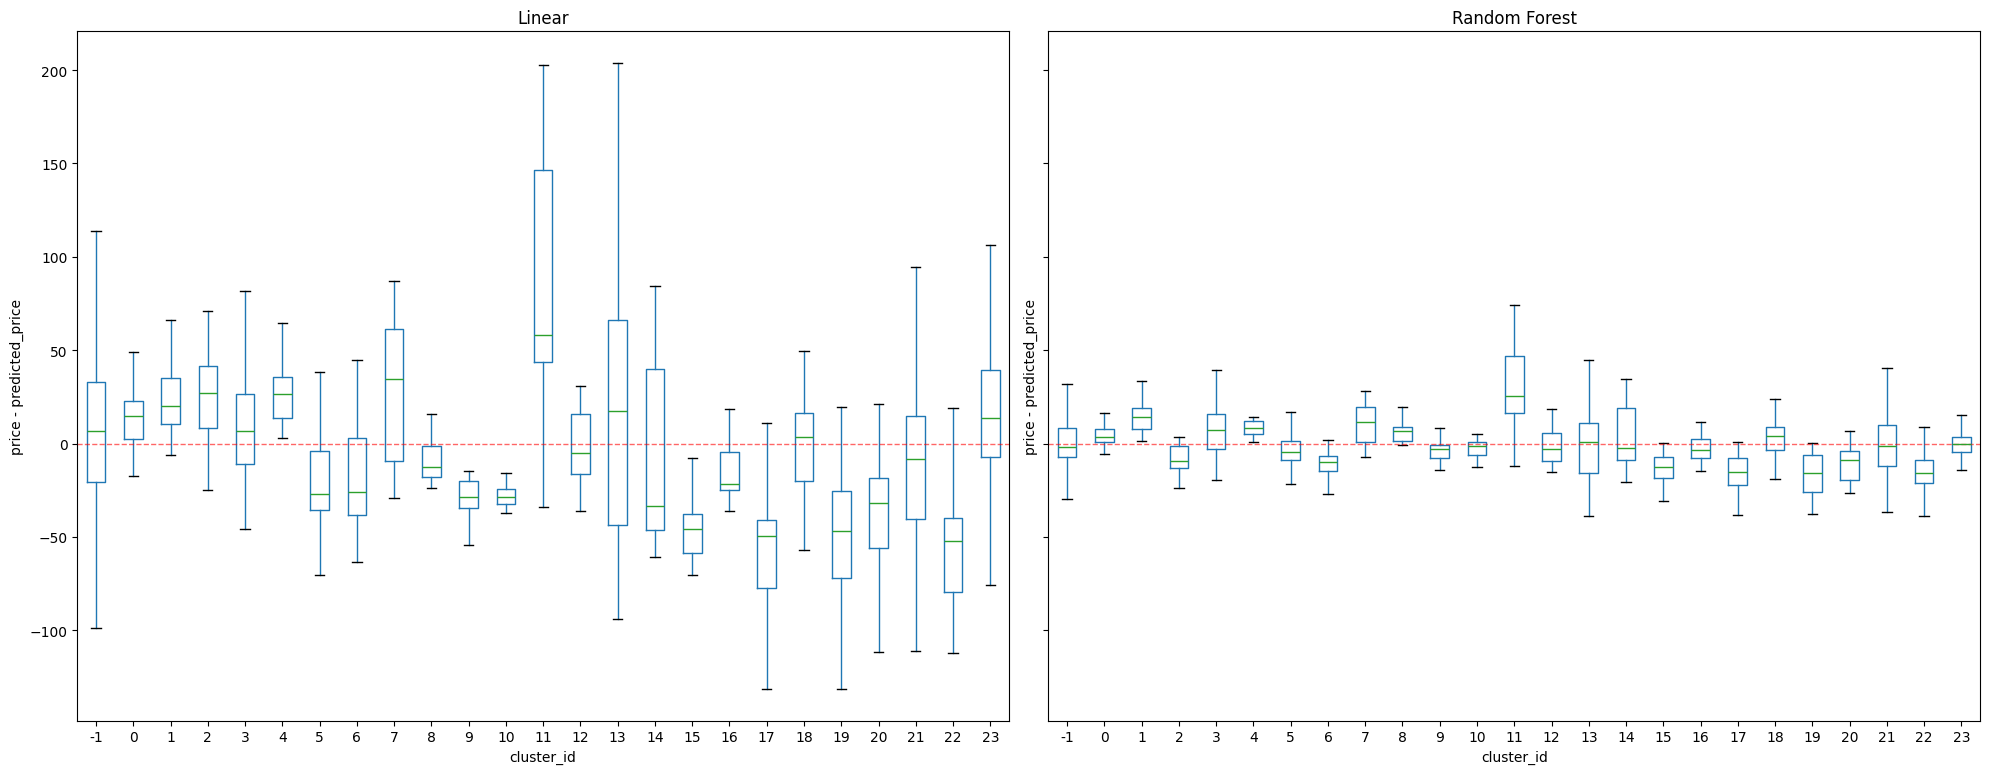

In [7]:
from src.visualizations.results import visualize_results_compare, visualize_map

predictions_linear = pipe_linear.predict(X)
diff_linear = y - predictions_linear
predictions_rf = pipe_random_forest.predict(X)
diff_rf = y - predictions_rf
visualize_results_compare(diff_linear, diff_rf, ids)

Interpretacja map
- Kolor zielony - zbyt mało ofert w regionie
- Kolor czerwony - zbyt dużo ofert w regionie

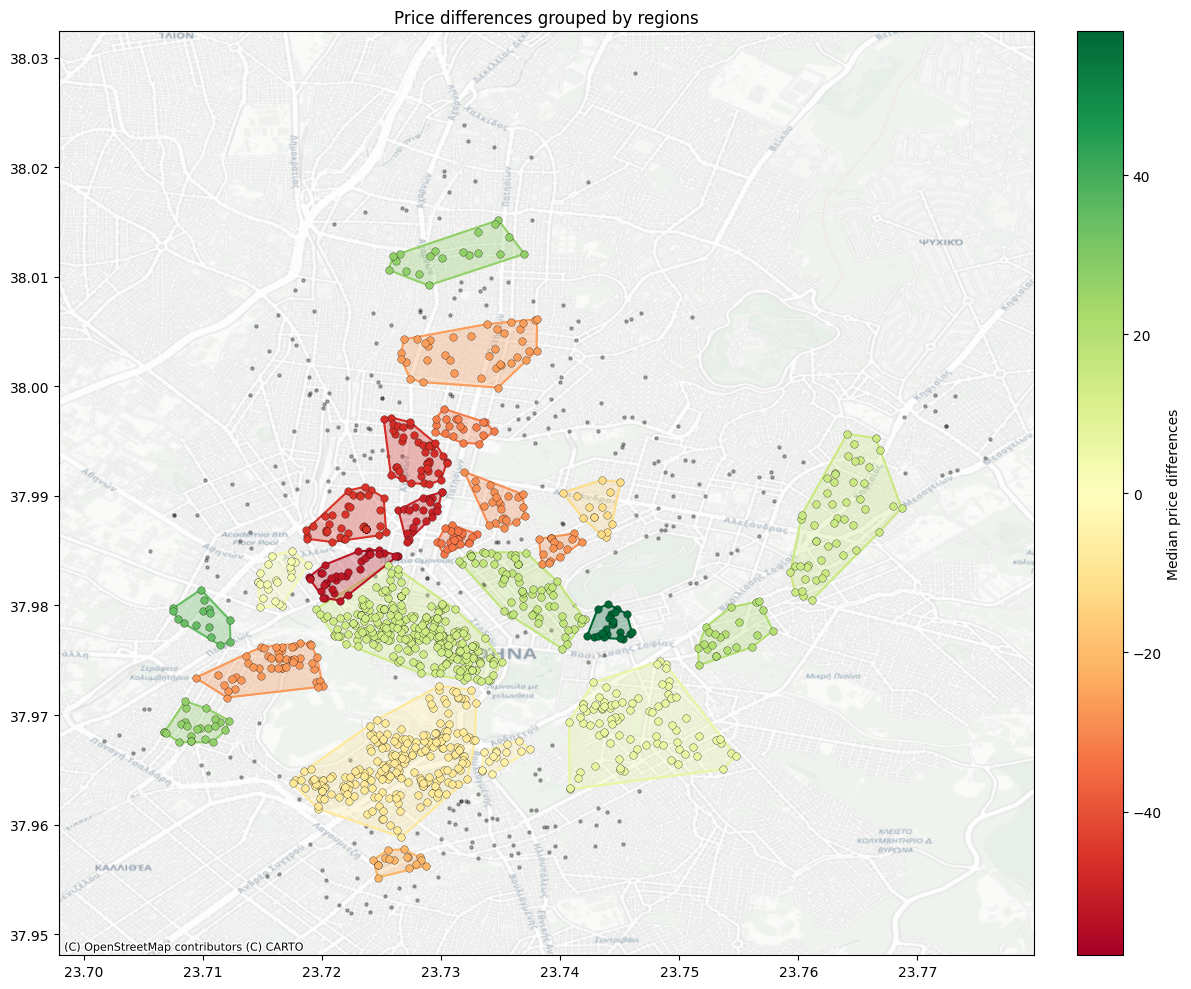

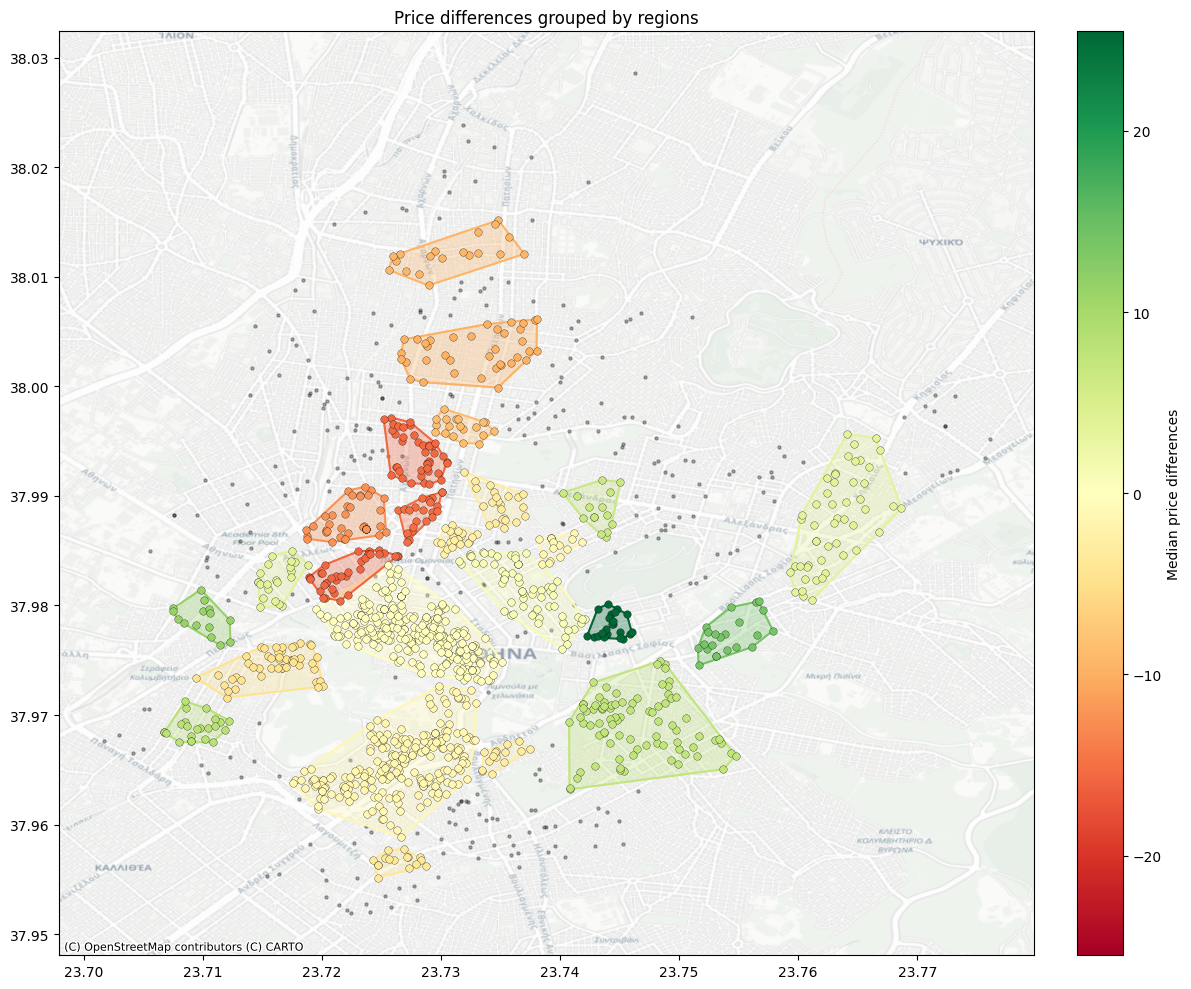

In [8]:
visualize_map(diff_linear, ids, listings)
visualize_map(diff_rf, ids, listings)

## Wnioski

1. **Błąd MAE** podczas uczenia modelu - różnica wartości między błędu między modelami jest niewielka. Nie mówi jasno czy stosowanie lasu losowego jest konieczne.
2. **Mapy** - wyniki dla obydwu modeli są stosunkowo podobne, trzeba się dobrze przyjrzeć, żeby zobaczyć różnicę.
3. **Wykresy statystyczne** - znacząco różnią się od siebie. Dla modelu regresji liniowej wyniki są bardziej skrajne, model nie jest w stanie wychwycić nieliniowych zależności, co prowadzi do bardzo dużych różnic predykcji w obrębie jednego klastra. Natomiast wyniki lasu losowego są bardziej stabilne, jest on w stanie dostrzec trudniejsze zależności, co przekłada się na mniej zaszumione wyniki.

Obserwacje wskazują, że w analizowanym problemie szukania regionów, w których liczba ofert jest zbyt duża **jest adekwatne** zastosowanie bardziej zaawansowanego modelu **lasu losowego**.

## Feature importance

Wartości *feature importance* zostaną wyciągnięte z pipeline'u modelu lasu losowego.

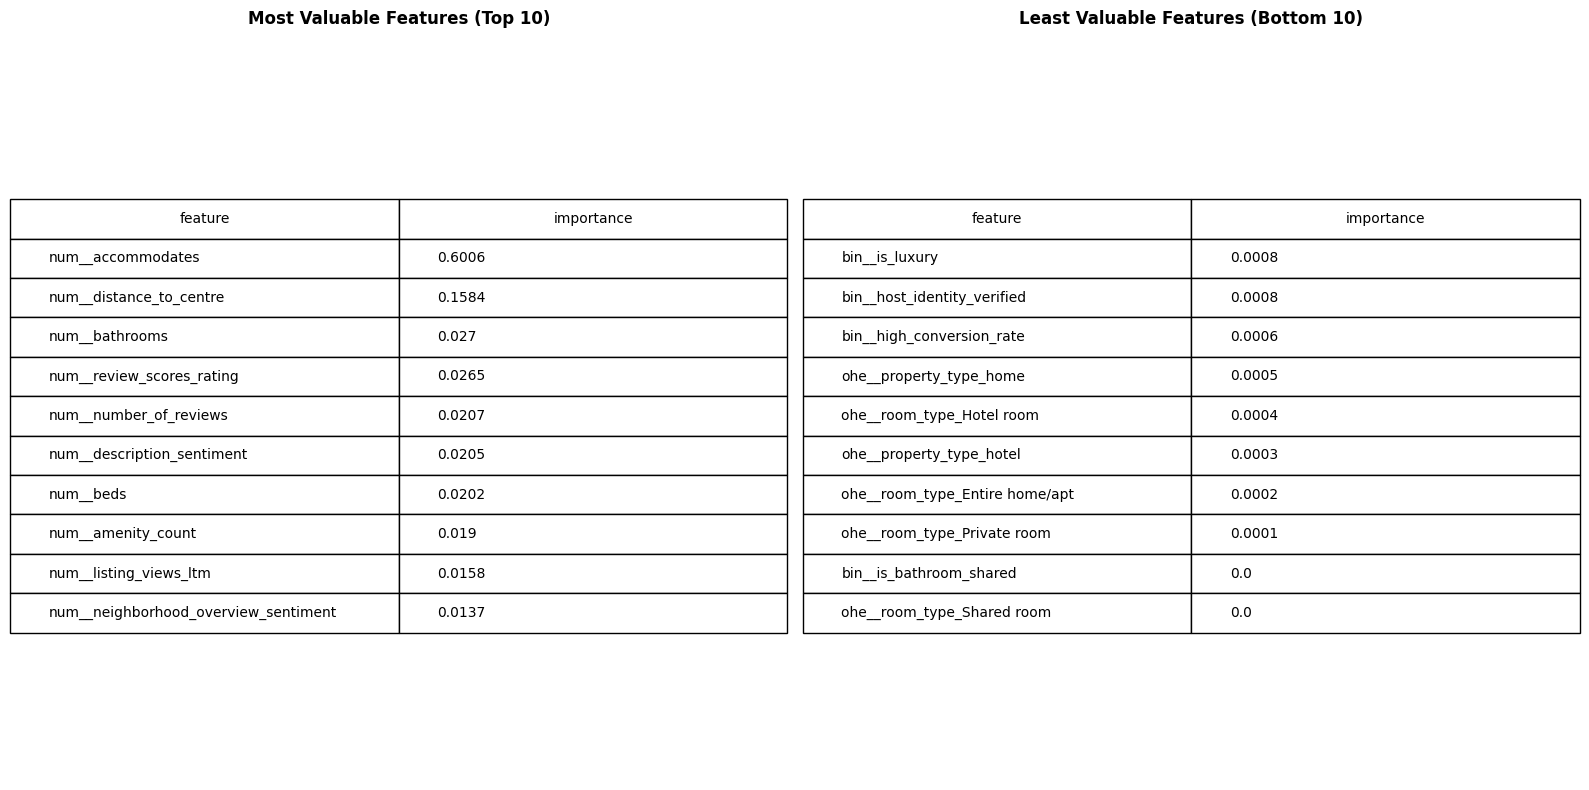

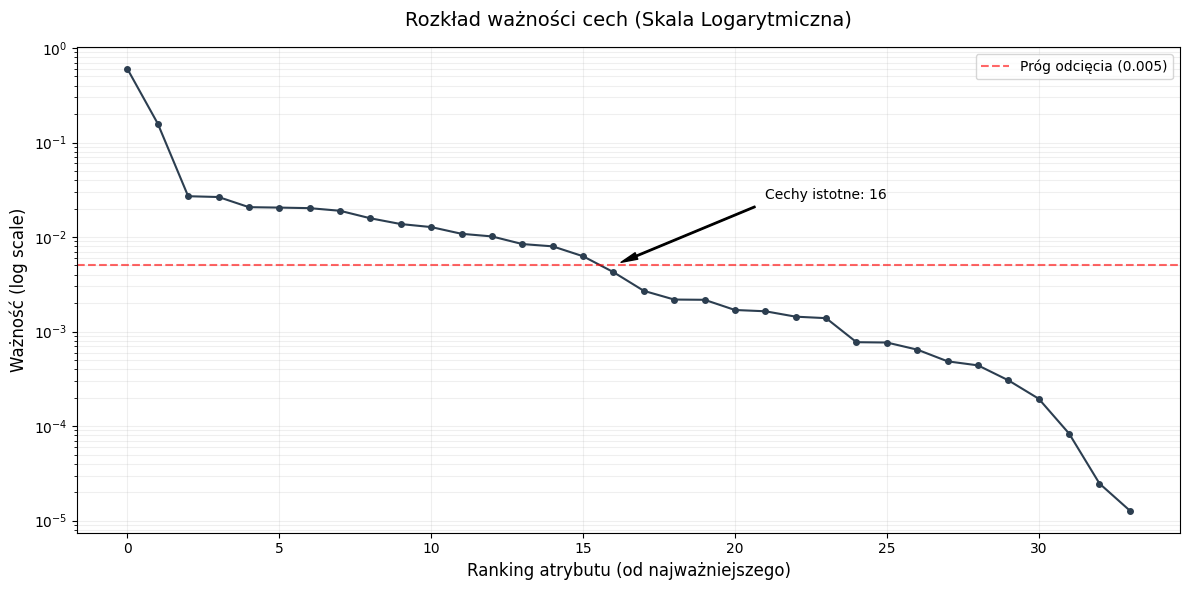

In [9]:
from src.visualizations.feature_importance import visualize_feature_importance_tables, plot_importance_distribution

visualize_feature_importance_tables(pipe_random_forest)
plot_importance_distribution(pipe_random_forest)